In [1]:
from occurrencerateclass import *
#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_moon
import estimate_PDF as pdf
import matplotlib.ticker
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [9]:
# get planet data
self = loadpickle('PipelineResults_TIC_sector34/TIC_results_0_10000_det')
g = self.disposition_human >= 0
assert g.sum() == 22

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


In [10]:
# get ephemerides
g1 = np.in1d(self.disposition_human, [2,2.5])
g2 = np.in1d(self.disposition_human, [0,1])
Ps = np.append(self.Ps_singletransit[g1], self.Ps[g2])
ehiPs = np.append(self.ehi_Ps_singletransit[g1], self.e_Ps[g2])
eloPs = np.append(self.elo_Ps_singletransit[g1], self.e_Ps[g2])
T0s = np.append(self.T0s[g1], self.T0s[g2])
eT0s = np.append(self.e_T0s[g1], self.e_T0s[g2])
ras = np.append(self.ras[g1], self.ras[g2])
decs = np.append(self.decs[g1], self.decs[g2])
tics = np.append(self.tics[g1], self.tics[g2])
dispositions_human = np.append(self.disposition_human[g1], self.disposition_human[g2])
#Ps = self.Ps[g]
#ehiPs = self.e_Ps[g]
#eloPs = self.e_Ps[g]
#T0s = self.T0s[g]
#ehiT0s = self.e_T0s[g]
#eloT0s = self.e_T0s[g]
#ras = self.ras[g]
#decs = self.decs[g]
#tics = self.tics[g]
#dispositions_human = self.disposition_human[g]

In [42]:
# define plotting functions
def plot_visibility(TIC, disposition, ra_deg, dec_deg, loc, UTCoffset, 
                    Ps=np.zeros(0), T0s=np.zeros(0), duration_days=6, saveplt=False):
    '''Plot the visibility (i.e. altitude or airmass) of a source from a fixed ground-based observatory.'''
    c = SkyCoord(ra_deg, dec_deg, frame='icrs', unit='deg')

    # define time array
    midnight = Time(date_mid) - UTCoffset
    delta_days = np.linspace(-duration_days/2., duration_days/2., 5000)*u.day
    times = midnight + delta_days
    frame = AltAz(obstime=times, location=loc)

    # get altitude vs time
    altazs = c.transform_to(frame)
    airmass = altazs.secz
    
    # get Sun's location
    sunaltazs = get_sun(times).transform_to(frame)

    # get Moon's location
    moonaltazs = get_moon(times).transform_to(frame)
    
    # plot airmass
    pltsecz = 0
    if pltsecz:
        plt.plot(delta_days, airmass)
        plt.ylim(1, 4)
        plt.xlabel('Delta Days')
        plt.ylabel('Airmass [Sec(z)]')
        
    # plot all sources
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    ax.plot(delta_days, sunaltazs.alt, color='r', label='Sun')
    ax.plot(delta_days, moonaltazs.alt, color=[0.75]*3, ls='--', label='Moon')
    img = ax.scatter(delta_days, altazs.alt, c=altazs.az, label='Target', lw=0, s=25, cmap=plt.get_cmap('rainbow'))
    ax.fill_between(delta_days.to('day').value, 0, 90, sunaltazs.alt < -0*u.deg, color='0.5', zorder=0)
    ax.fill_between(delta_days.to('day').value, 0, 90, sunaltazs.alt < -18*u.deg, color='k', zorder=0)
    
    cbarax = fig.add_axes([.96, .1, .025, .8])
    cbar = fig.colorbar(img, cax=cbarax)
    cbar.set_label('Azimuth [deg]', fontsize=12)
    
    mn, mx = ax.set_ylim(0, 90)
    ax.set_xlim((delta_days.to('day').value.min(),delta_days.to('day').value.max()))
    ax.set_xlabel('Days since local midnight on %s'%date_str, fontsize=12)
    ax.set_ylabel('Altitude [deg]', fontsize=12)
    ax.set_title('TIC = %i, Disposition = %i\nRA = %.3f deg, Dec = %.3f deg'%(TIC,disposition,ra_deg,dec_deg), y=1.02)

    # plot planet transit posteriors
    if (len(Ps)==3) & (len(T0s)==3):
        P, ehiP, eloP = Ps
        T0, ehiT0, eloT0 = T0s
        y_edges, x_edges, Tmids = _compute_transit_times(P, ehiP, eloP, T0, ehiT0, eloT0, UTCoffset,
                                                         duration_days=duration_days)
        for i in range(y_edges.shape[0]):
            ax.plot(x_edges[i,1:]-np.diff(x_edges[i])[0]/2, y_edges[i]/y_edges[i].max()*80, 'w-')
            ax.axvline(Tmids[i], ls='--', lw=2, color='b')
            if i == 0:
                ax.fill_between(x_edges[i,1:]-np.diff(x_edges[i])[0]/2, np.zeros(y_edges[i].size), 
                                y_edges[i]/y_edges[i].max()*80, color='b', alpha=.4, label='Mid-transit time posterior')
            else:
                ax.fill_between(x_edges[i,1:]-np.diff(x_edges[i])[0]/2, np.zeros(y_edges[i].size), 
                                y_edges[i]/y_edges[i].max()*80, color='b', alpha=.5)
            
    # add airmass axis
    ax2 = ax.twinx()
    altitude_func = lambda X: 90 - np.rad2deg(np.arccos(1./X))
    ax2.set_ylim(0,90)
    airmasses = np.array([1,1.1,1.2,1.4,2,5])
    yticks = np.sort(altitude_func(airmasses))
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(airmasses[::-1])
    ax2.set_ylabel('Airmass', fontsize=12)
    for h in altitude_func(airmasses): ax2.axhline(h, color='grey', lw=.8)
        
    # add months for yearly plots
    #ax2 = ax.twinx()
    #xticks = np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31])
    #xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    #ax2.set_xticks(xticks)
    #ax2.set_xticklabels(xticklabels)
    fig.legend(loc='upper left')
    plt.savefig('DragonflyPlots/DragonflyPlots_sector34/Dragonfly_visibility_TIC%i.png'%TIC)
    plt.show()
        
        
def _compute_transit_times(P, ehiP, eloP, T0, ehiT0, eloT0, UTCoffset_obssite, 
                           duration_days=6.5, Nsamp=1e3, Nbins=30):
    '''Compute the transit probability over a range of dates available for transit follow-up and 
    return for plotting.'''
    # define time array
    midnight = Time(date_mid) - UTCoffset_obssite
    delta_days = np.linspace(-duration_days/2., duration_days/2., 5000)*u.day
    times = midnight + delta_days
    
    # compute transit probability
    _,_,samp_P = pdf.get_samples_from_percentiles(P, ehiP, eloP, Nsamp=int(Nsamp))
    _,_,samp_T0 = pdf.get_samples_from_percentiles(T0, ehiT0, eloT0, Nsamp=int(Nsamp))
    Norbits = int(np.round((midnight.jd - T0) / P)) - 1
    Ntransits_inwindow = int(np.ceil(duration_days / P)) + 1
    Nbins = int(Nbins)
    y_edges, x_edges = np.zeros((Ntransits_inwindow,Nbins)), np.zeros((Ntransits_inwindow,Nbins+1))
    Tmids = np.zeros(Ntransits_inwindow)
    for i in range(Ntransits_inwindow):
        Tmids[i] = T0 + (Norbits+i)*P
        print 'Most likely transit time = %.5f JD'%Tmids[i]
        samp_t = samp_T0 + (Norbits+i)*samp_P
        y_edges[i], x_edges[i] = np.histogram(samp_t, bins=Nbins)
    
    # return delta days
    x_edges -= midnight.jd
    Tmids -= midnight.jd
    return y_edges, x_edges, Tmids

In [43]:
# define observing location
lat = 32 + 54./60       # New mexico skies
lon = -105 + 32./60
elevation = 2788        # meters
UTCoffset = -6*u.hour   # New mexico
loc = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=elevation*u.m)
date_mid, date_str = '2019-2-19 00:00:00', 'Feb 19, 2019'

23.1405442455 26.5970531499 39.7992864556
2458399.51507 2458399.51565 2458399.51624
Most likely transit time = 2458505.90387 JD
Most likely transit time = 2458532.50092 JD


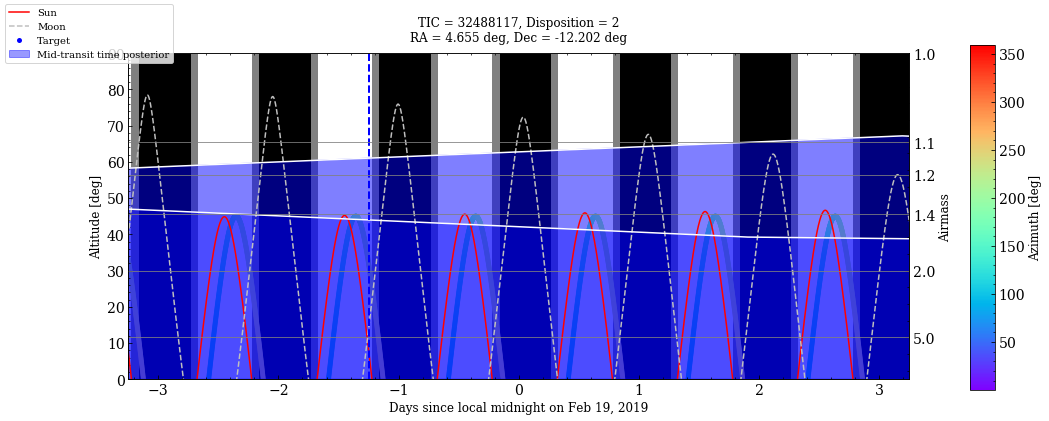

24.5900637707 30.5754631551 81.6616037643
2458395.40839 2458395.40988 2458395.41136
Most likely transit time = 2458517.71173 JD
Most likely transit time = 2458548.28719 JD


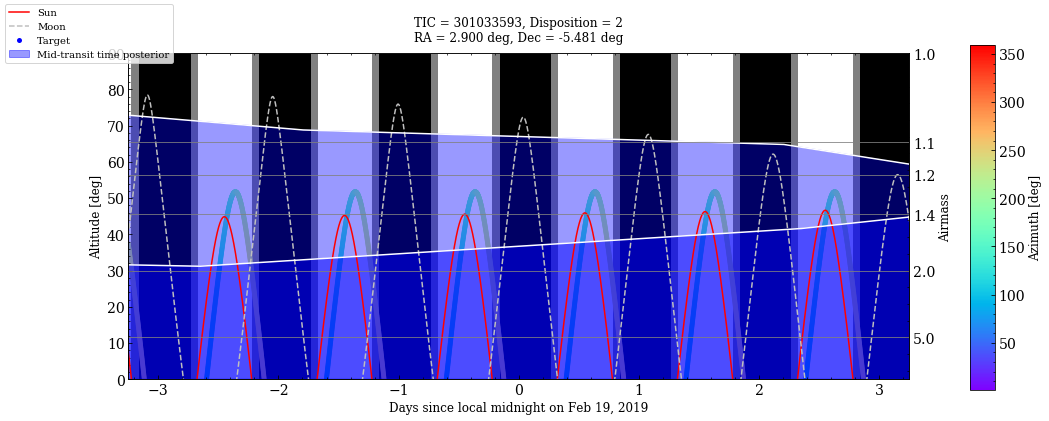

23.7083450216 34.4647985203 69.2415256169
2458429.64006 2458429.64085 2458429.64163
Most likely transit time = 2458498.57045 JD
Most likely transit time = 2458533.03525 JD


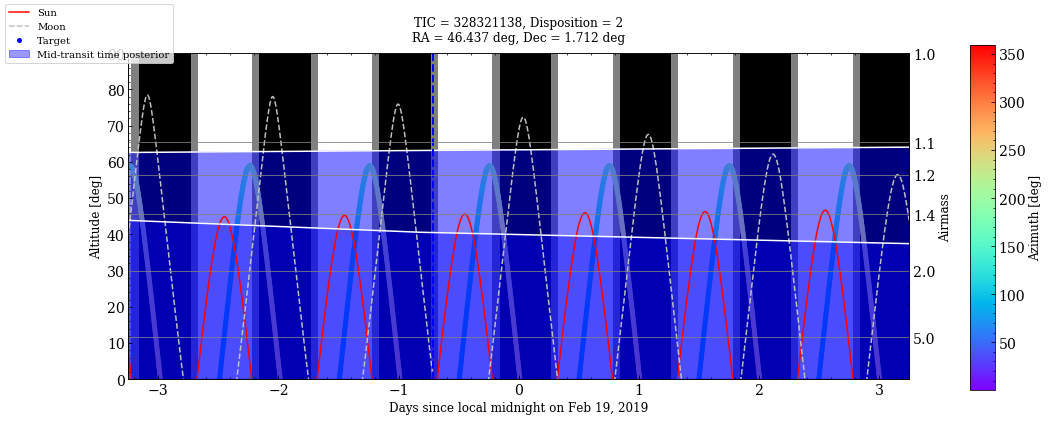

16.6312136364 25.9753056038 46.2630960844
2458398.67654 2458398.67821 2458398.67988
Most likely transit time = 2458502.57943 JD
Most likely transit time = 2458528.55474 JD


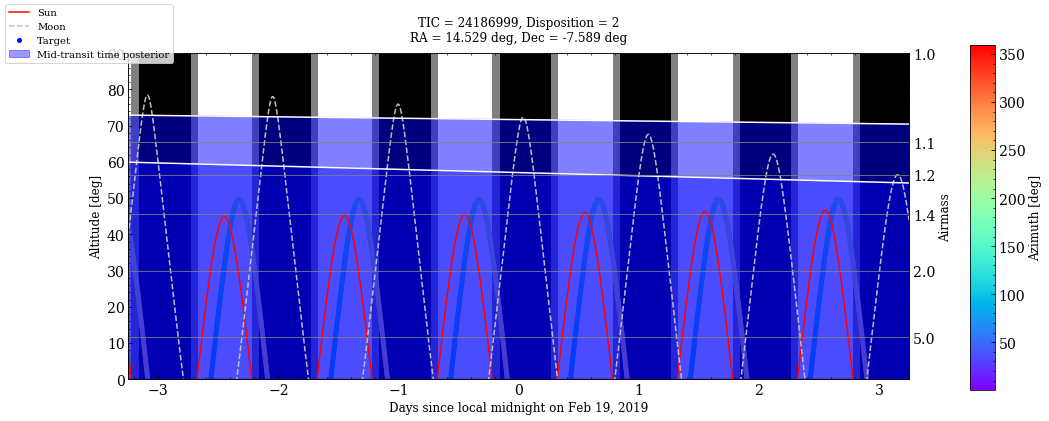

22.246779039 39.192616664 91.766434921
2458402.80879 2458402.81183 2458402.81486
Most likely transit time = 2458481.19706 JD
Most likely transit time = 2458520.38968 JD


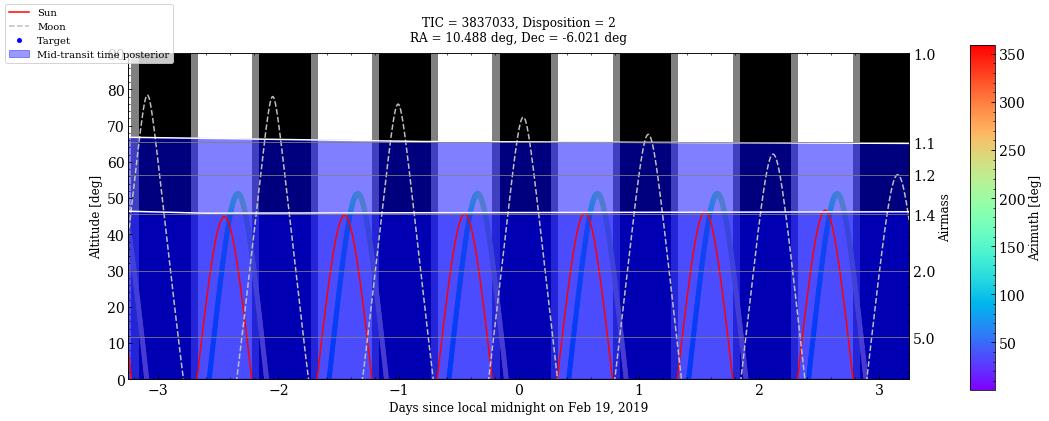

32.5257098868 53.2583451045 119.472096731
2458423.09068 2458423.09238 2458423.09408
Most likely transit time = 2458476.35072 JD
Most likely transit time = 2458529.60907 JD


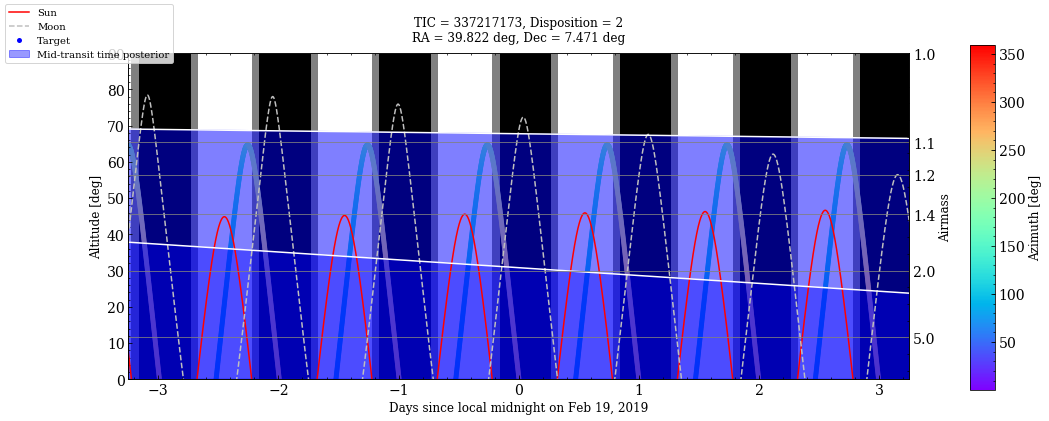

5.36142359116 5.36174817056 5.36207274995
2458418.05335 2458418.05726 2458418.06118
Most likely transit time = 2458530.65398 JD
Most likely transit time = 2458536.01572 JD
Most likely transit time = 2458541.37747 JD


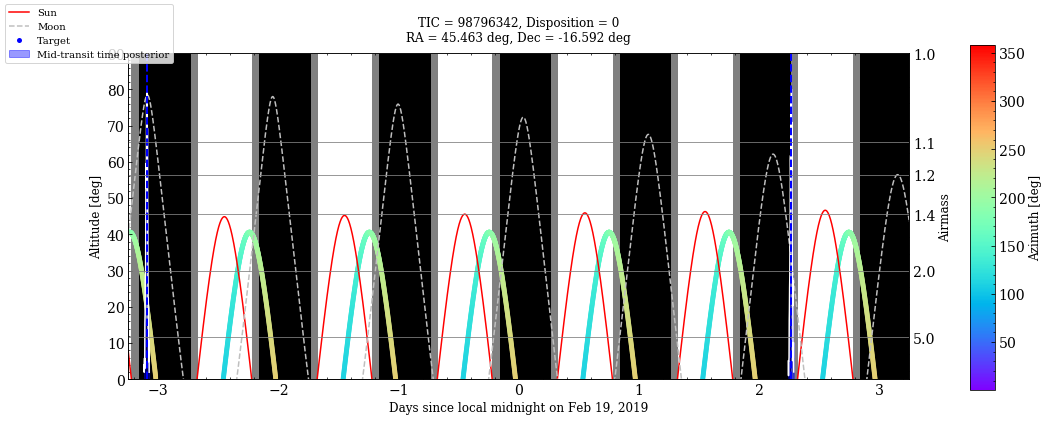

13.1713161583 13.1725956167 13.1738750751
2458414.90053 2458414.91332 2458414.92611
Most likely transit time = 2458520.29409 JD
Most likely transit time = 2458533.46668 JD


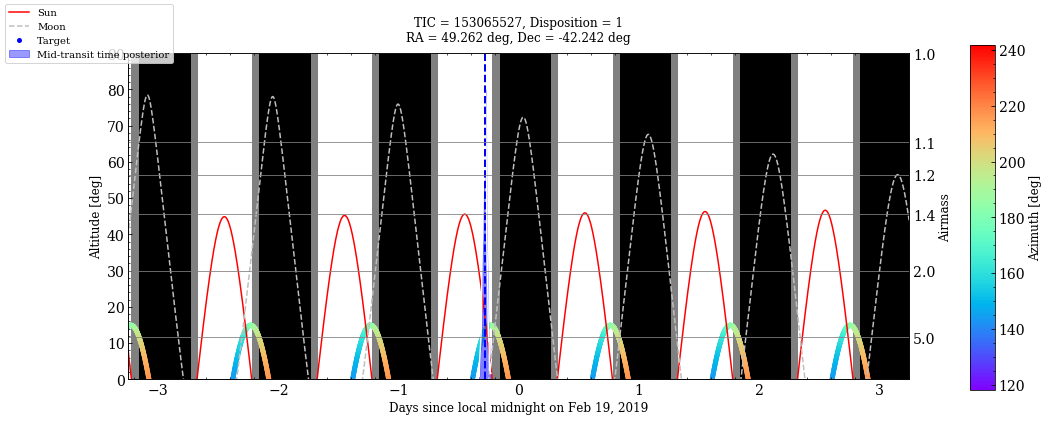

5.36079824453 5.36115777912 5.3615173137
2458418.06067 2458418.06171 2458418.06275
Most likely transit time = 2458530.64602 JD
Most likely transit time = 2458536.00718 JD
Most likely transit time = 2458541.36834 JD


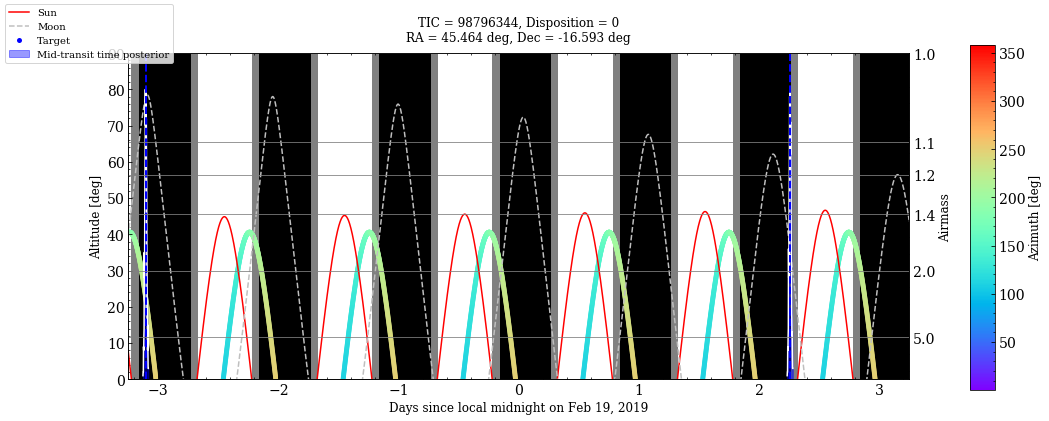

18.4437791921 18.4462079593 18.4486367266
2458380.08583 2458380.08944 2458380.09304
Most likely transit time = 2458509.21289 JD
Most likely transit time = 2458527.65910 JD


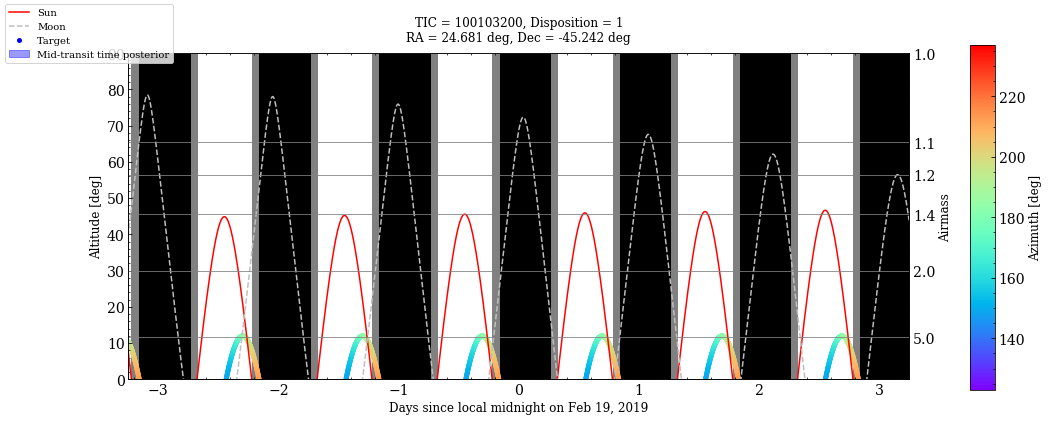

2.49151419616 2.49189633076 2.49227846535
2458414.15185 2458414.15745 2458414.16305
Most likely transit time = 2458531.27658 JD
Most likely transit time = 2458533.76848 JD
Most likely transit time = 2458536.26037 JD
Most likely transit time = 2458538.75227 JD


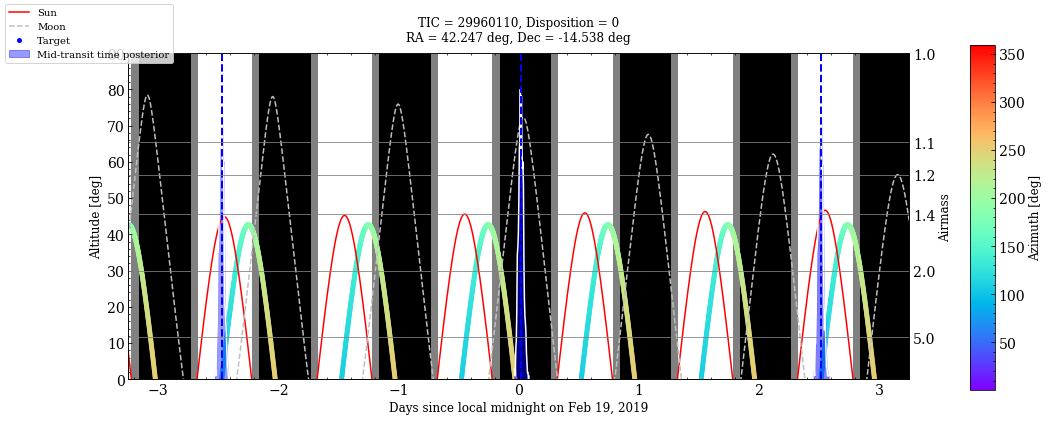

13.5504281574 13.5556750018 13.5609218462
2458430.65838 2458430.66071 2458430.66304
Most likely transit time = 2458525.55044 JD
Most likely transit time = 2458539.10611 JD


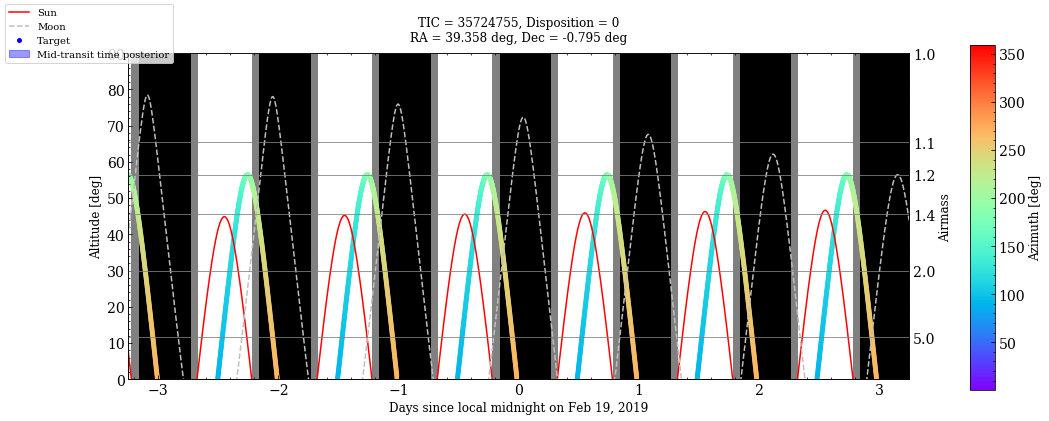

5.97533974904 5.97606976862 5.97679978821
2458361.63332 2458361.64103 2458361.64874
Most likely transit time = 2458528.97098 JD
Most likely transit time = 2458534.94705 JD
Most likely transit time = 2458540.92312 JD


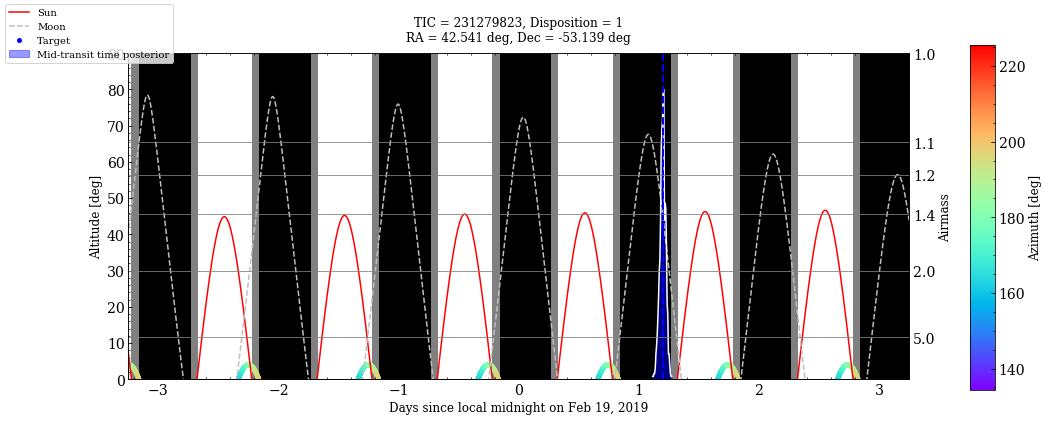

12.0033824723 12.011011218 12.0186399638
2458404.69157 2458404.69369 2458404.69581
Most likely transit time = 2458524.80380 JD
Most likely transit time = 2458536.81481 JD


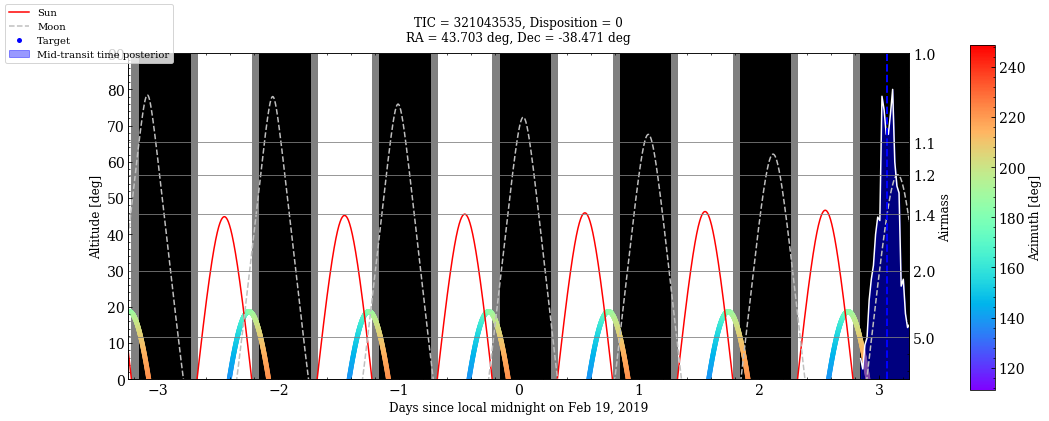

3.99027845666 3.99206015054 3.99384184442
2458401.00413 2458401.00449 2458401.00485
Most likely transit time = 2458528.75041 JD
Most likely transit time = 2458532.74247 JD
Most likely transit time = 2458536.73453 JD


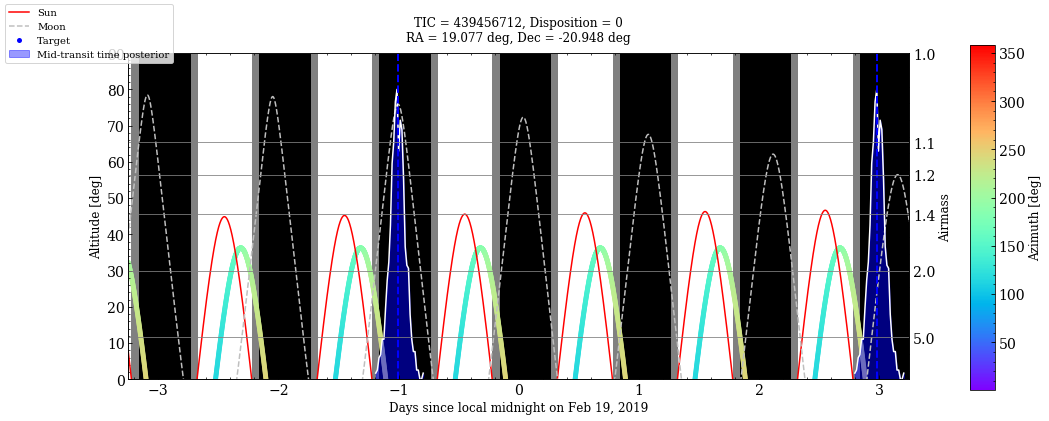

2.85384774202 2.85397134574 2.85409494945
2458364.70279 2458364.70697 2458364.71115
Most likely transit time = 2458530.23731 JD
Most likely transit time = 2458533.09128 JD
Most likely transit time = 2458535.94525 JD
Most likely transit time = 2458538.79923 JD


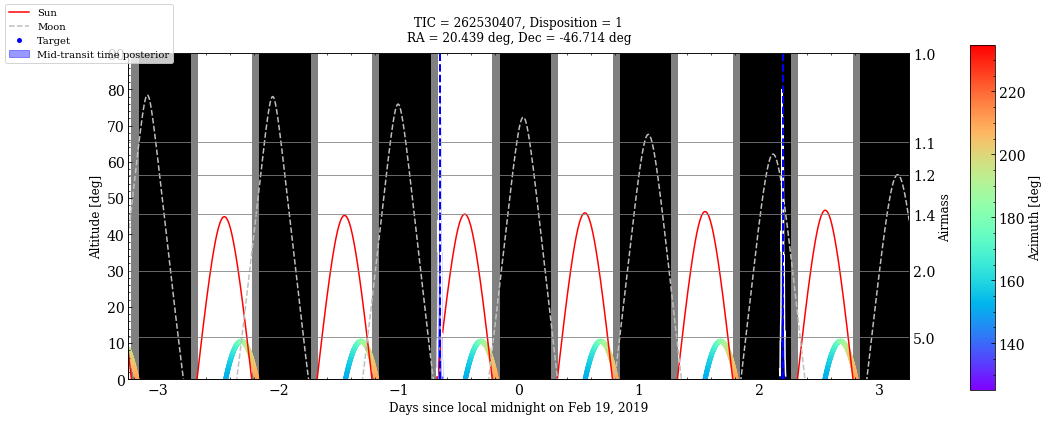

8.35048649471 8.35738342267 8.36428035064
2458403.10268 2458403.10325 2458403.10382
Most likely transit time = 2458528.46400 JD
Most likely transit time = 2458536.82139 JD


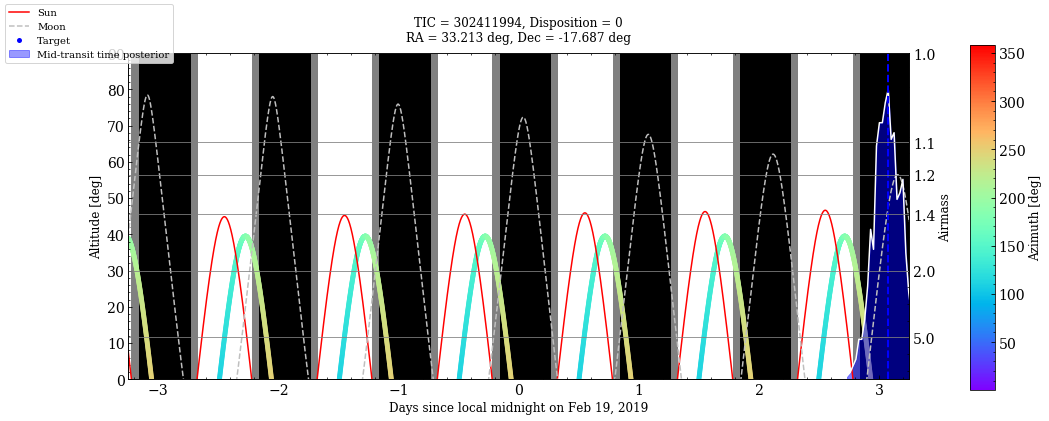

5.65941064547 5.65951865257 5.65962665968
2458434.77511 2458434.77892 2458434.78272
Most likely transit time = 2458525.33122 JD
Most likely transit time = 2458530.99073 JD
Most likely transit time = 2458536.65025 JD


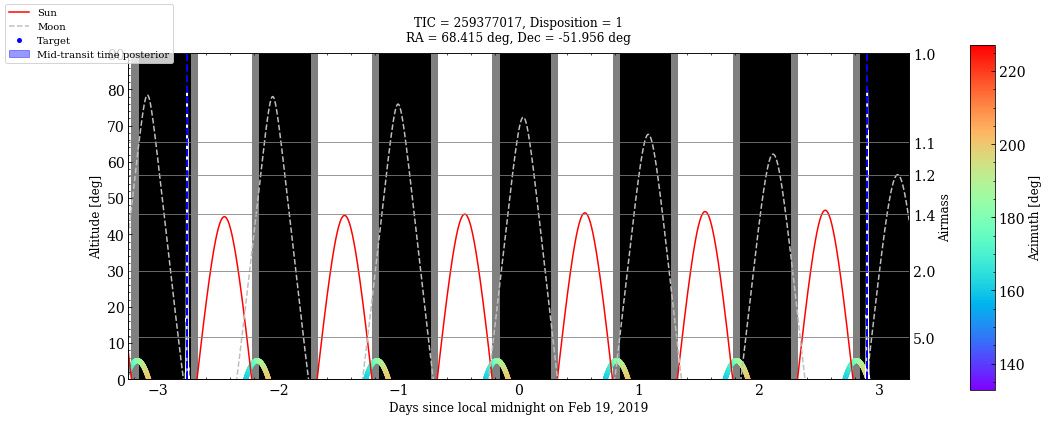

4.76110934327 4.7616777362 4.76224612914
2458352.46058 2458352.46295 2458352.46533
Most likely transit time = 2458528.64503 JD
Most likely transit time = 2458533.40671 JD
Most likely transit time = 2458538.16838 JD


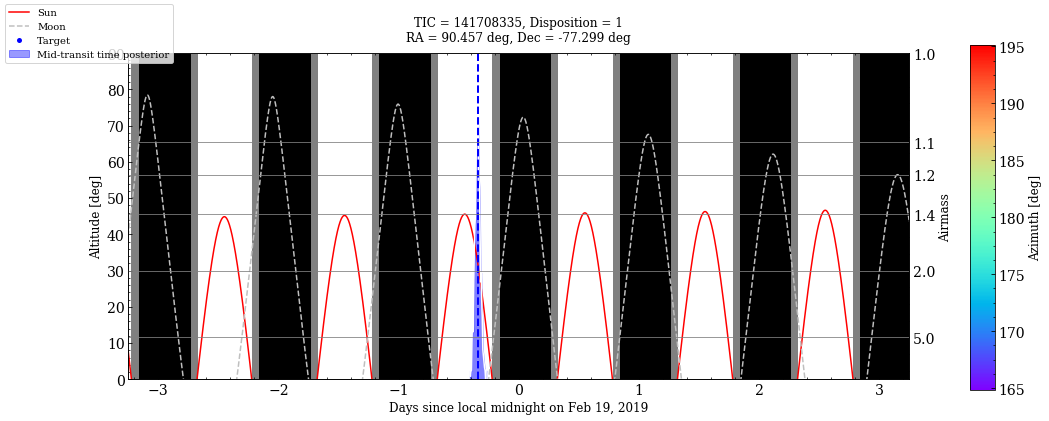

3.99548247604 3.99615843451 3.99683439298
2458393.01729 2458393.01832 2458393.01935
Most likely transit time = 2458528.88771 JD
Most likely transit time = 2458532.88387 JD
Most likely transit time = 2458536.88002 JD


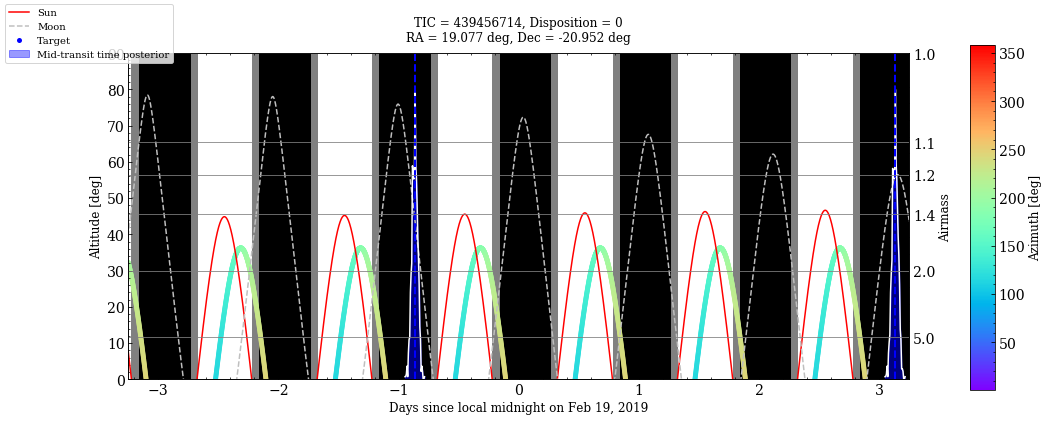

2.49133429549 2.49168836754 2.49204243959
2458429.10964 2458429.11107 2458429.1125
Most likely transit time = 2458531.27029 JD
Most likely transit time = 2458533.76198 JD
Most likely transit time = 2458536.25367 JD
Most likely transit time = 2458538.74536 JD


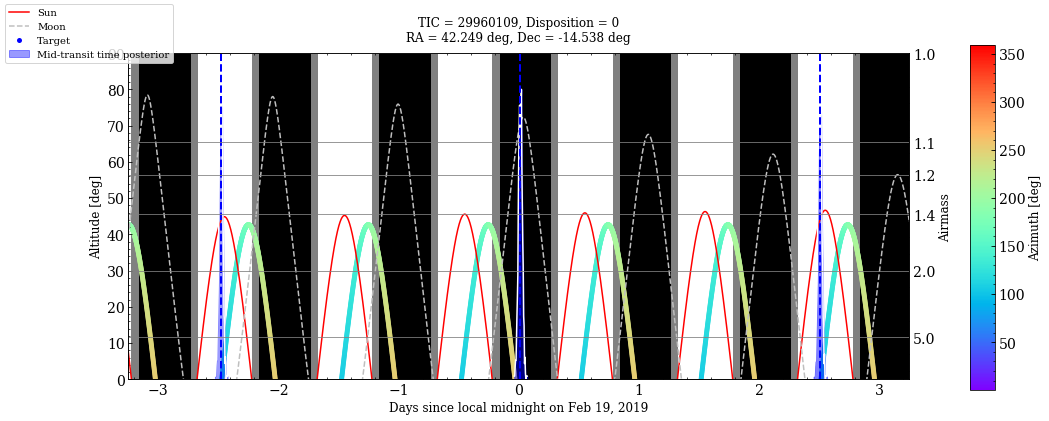

7.87932899085 7.88324042068 7.8871518505
2458429.12089 2458429.12544 2458429.13
Most likely transit time = 2458523.72433 JD
Most likely transit time = 2458531.60757 JD


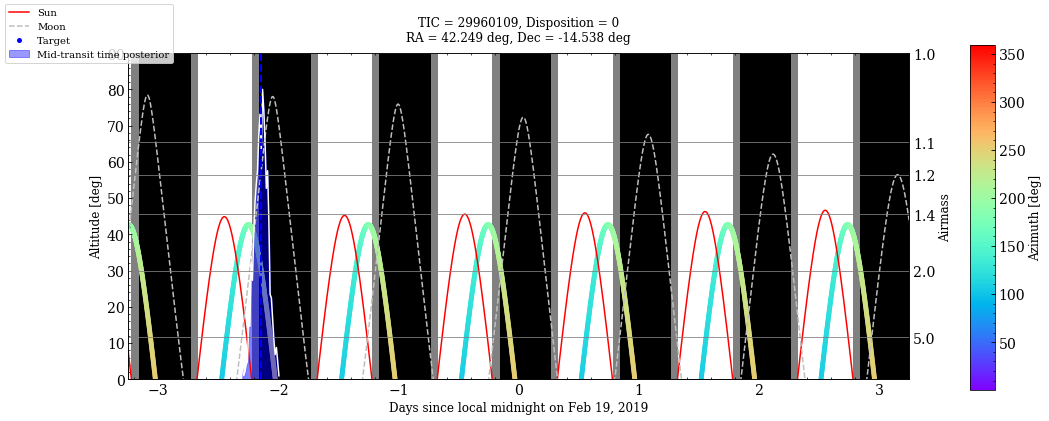

In [44]:
for i in range(tics.size):
    plot_visibility(tics[i], dispositions_human[i], ras[i], decs[i], loc, UTCoffset, Ps=[Ps[i],ehiPs[i],eloPs[i]], 
                    T0s=[T0s[i],ehiT0s[i],eloT0s[i]], duration_days=6.5, saveplt=True)

In [128]:
#g = np.in1d(tics, [337217173, 328321138])
g1 = self.tics == 337217173
g2 = self.tics == 328321138
print self.rpRs_singletransit[g2]**2*1e6

[    0.         14446.67306931]


(<matplotlib.legend.Legend at 0x12976a790>, None)

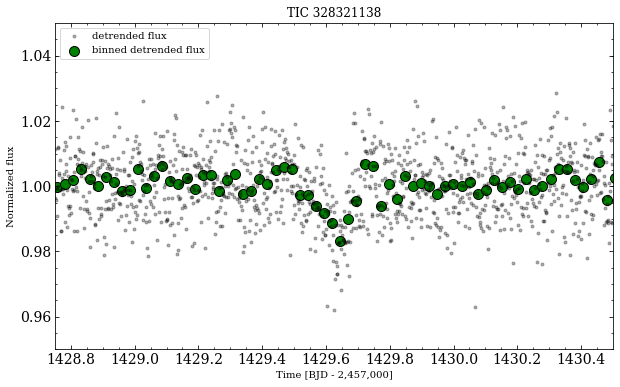

In [127]:
t0 = 2457000
d = loadpickle('PipelineResults_TIC_sector34/TIC_328321138/LC_-00099')
T0 = d.params_guess[0,1]
tbin, fbin,_ = boxcar(d.bjd-t0, d.fcorr, d.ef, dt=.03)
plt.figure(figsize=(10,6))
plt.plot(d.bjd-t0, d.fcorr, 'k.', alpha=.3, label='detrended flux')
plt.scatter(tbin, fbin, s=100, edgecolor='k', facecolor='g', label='binned detrended flux')
#plt.xlim((1411.1, 1413.2)), plt.ylim((.98,1.02))
plt.xlim((1428.75, 1430.5)), plt.ylim((.95,1.05))
plt.xlabel('Time [BJD - 2,457,000]'), plt.ylabel('Normalized flux'), plt.title('TIC %i'%d.tic)
plt.legend(loc='upper left'), plt.savefig('DragonflyPlots/DragonflyPlots_sector34/TIC%i_ST_LC.png'%d.tic)

In [124]:
d.params_guess[0,1]-t0

1429.639917332679